# Setup

In [25]:
# Library
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [26]:
# GPU Setup
seed = 43
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

cuda:0


# Data

In [27]:
# Here for this task I am using stock data of Amazon
amazon_data = pd.read_csv('data/AMZN.csv')
amazon_data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,15-05-1997,0.096354,0.121875,1443120000,0.125000,0.097917,0.097917
1,16-05-1997,0.085417,0.098438,294000000,0.098958,0.086458,0.086458
2,19-05-1997,0.081250,0.088021,122136000,0.088542,0.085417,0.085417
3,20-05-1997,0.081771,0.086458,109344000,0.087500,0.081771,0.081771
4,21-05-1997,0.068750,0.081771,377064000,0.082292,0.071354,0.071354


In [28]:
# Converting date column to data type and setting it as index for conviniance 
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'], dayfirst=True)
amazon_data.set_index('Date', inplace=True)

In [29]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6438 entries, 1997-05-15 to 2022-12-12
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Low             6438 non-null   float64
 1   Open            6438 non-null   float64
 2   Volume          6438 non-null   int64  
 3   High            6438 non-null   float64
 4   Close           6438 non-null   float64
 5   Adjusted Close  6438 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 352.1 KB


In [30]:
# Checking for null values in the dataset 
amazon_data.isnull().sum()

Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

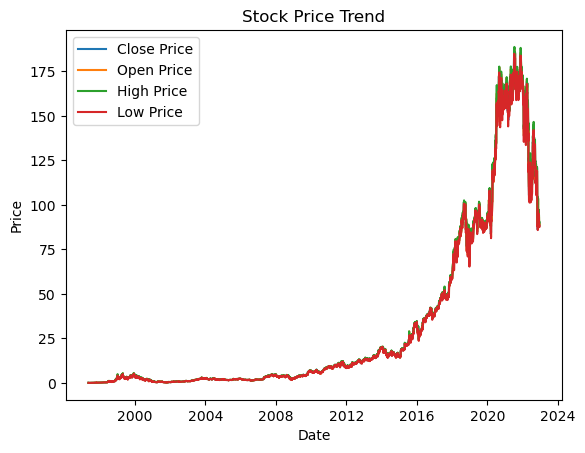

In [31]:
# Ploting stock index prices ('Close', 'Open', 'High', 'Low') to understand the stock price trend  
plt.plot(amazon_data['Close'], label='Close Price')
plt.plot(amazon_data['Open'], label='Open Price')
plt.plot(amazon_data['High'], label='High Price')
plt.plot(amazon_data['Low'], label='Low Price')
plt.legend()
plt.title('Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

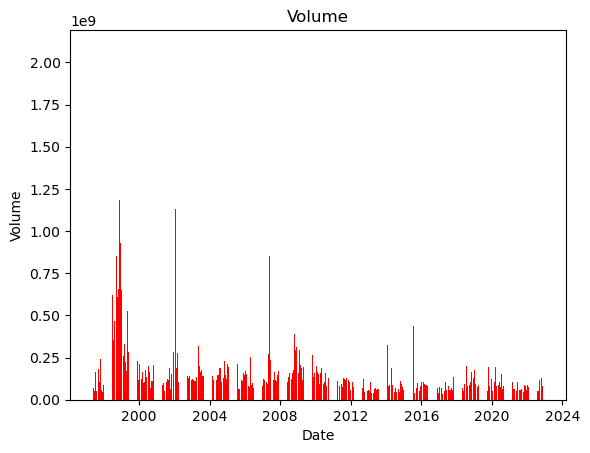

In [32]:
# Ploting the volume to understand the daily transsection trend
plt.bar(amazon_data.index, amazon_data['Volume'], color='red')
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## Data Preparation

In [ ]:
# For this task i will ignore the Adjusted Close index
amazon_data_prep = amazon_data.drop(columns=['Adjusted Close'], inplace=False)
amazon_data_prep.head()

,Low,Open,Volume,High,Close
Date,,,,,
1997-05-15,0.096354,0.121875,1443120000,0.125000,0.097917
1997-05-16,0.085417,0.098438,294000000,0.098958,0.086458
1997-05-19,0.081250,0.088021,122136000,0.088542,0.085417
1997-05-20,0.081771,0.086458,109344000,0.087500,0.081771
1997-05-21,0.068750,0.081771,377064000,0.082292,0.071354


In [ ]:
# To keep track of the date
dates = amazon_data_prep.index.to_list()

In [35]:
# Scaling the data using MinMaxScaler to bound the values in similar range. In this case [0,1]
scaler = MinMaxScaler()
amazon_data_prep = scaler.fit_transform(amazon_data_prep)

In [ ]:
# Function to convert the data into sequence for RNN input. Here I am taking past 7 days of index (Low, Open, Volume, High, Close) as input (X) to LSTM and 
# the next day's Close price as target value
def convert_data_to_sequence(data, time_stamp=7):
  X = []
  y = []
  target_dates = []

  for i in range(len(data) - time_stamp):
    sequence = [r for r in data[i:i+time_stamp]]
    X.append(sequence)

    target = [data[i+time_stamp][-1]]
    y.append(target)

    target_dates.append(dates[i + time_stamp])
    
  return np.array(X), np.array(y), target_dates


In [37]:
# Convering data to the sequence (required format)
X, y, date = convert_data_to_sequence(amazon_data_prep)
print(X.shape, y.shape)

(6431, 7, 5) (6431, 1)


In [38]:
# Spliting the data into Train, Validation and Test set
# Here I am spliting the data with Train:Val:Test = 80:10:10 ratio

def split_data(X, y):
    # Calculating the splits 
    train_split = math.ceil(X.shape[0]*0.8)
    num_data_in_val_n_test = (X.shape[0] - train_split)//2
    val_split = train_split + num_data_in_val_n_test

    # Splited data
    train_data_X = X[:train_split]
    train_data_y = y[:train_split]

    val_data_X = X[train_split:val_split]
    val_data_y = y[train_split:val_split]

    test_data_X = X[val_split:]
    test_data_y = y[val_split:]
    target_date = date[val_split:]
    
    return train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y, target_date

In [39]:
train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y, target_date = split_data(X, y)

# Shape of the data
print('Shape of the data: ')
print(train_data_X.shape, val_data_X.shape, test_data_X.shape)
print(train_data_y.shape, val_data_y.shape, test_data_y.shape)

Shape of the data: 
(5145, 7, 5) (643, 7, 5) (643, 7, 5)
(5145, 1) (643, 1) (643, 1)


In [40]:
# Function to create tensors from numpy array
def conver_to_tensor(train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y):
    train_data_X = torch.tensor(train_data_X, dtype=torch.float)
    train_data_y = torch.tensor(train_data_y, dtype=torch.float)

    val_data_X = torch.tensor(val_data_X, dtype=torch.float)
    val_data_y = torch.tensor(val_data_y, dtype=torch.float)

    test_data_X = torch.tensor(test_data_X, dtype=torch.float)
    test_data_y = torch.tensor(test_data_y, dtype=torch.float)

    return train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y

In [41]:
train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y = conver_to_tensor(train_data_X, train_data_y, 
                                                                                                val_data_X, val_data_y, test_data_X, test_data_y)

# Shape of the data
print('Shape: ')
print(train_data_X.shape, val_data_X.shape, test_data_X.shape)
print(train_data_y.shape, val_data_y.shape, test_data_y.shape)

Shape: 
torch.Size([5145, 7, 5]) torch.Size([643, 7, 5]) torch.Size([643, 7, 5])
torch.Size([5145, 1]) torch.Size([643, 1]) torch.Size([643, 1])


In [18]:
# Model -> (LSTM)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # As train_data_X == (observation, seq, input_size) so batch_first=True
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        # Taking only the last time step output as here I am following many to one method
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

In [ ]:
# Training and testing functions

# training function
def training_step(model, train_data_X, train_data_y, optimizer, criterion):
    model.train()
    train_loss = 0.0

    # move data to GPU
    train_data_X = train_data_X.to(device)
    train_data_y = train_data_y.to(device)

    # zero the parameter gradients 
    optimizer.zero_grad()

    # forward pass
    outputs = model(train_data_X)
    loss = criterion(outputs, train_data_y)

    # backward pass
    loss.backward()
    optimizer.step()

    # metric
    train_loss = loss.item()
    return train_loss


# validation function
def val_step(model, val_data_X, val_data_y, criterion):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        # move data to GPU
        val_data_X = val_data_X.to(device)
        val_data_y = val_data_y.to(device)

        # forward pass
        outputs = model(val_data_X)
        loss = criterion(outputs, val_data_y)

        # metric
        val_loss = loss.item()

    return val_loss

# test function
def test_step(model, test_data_X, test_data_y, scaler):
    model.eval()
    with torch.no_grad():
        # move data to GPU
        test_data_X = test_data_X.to(device)

        # forward pass
        predictions = model(test_data_X).cpu().numpy()
        test_data_y = test_data_y.cpu().numpy()
    
    eval_loss = mean_squared_error(test_data_y, predictions)
    
    # inverse scaling
    # Copy the same column five times as our MinMaxScalar had 5 column for scaling 
    test_data_y_copies = np.repeat(test_data_y, test_data_X.shape[2], axis=-1)
    test_data_y = scaler.inverse_transform(test_data_y_copies)[:,0]

    prediction_copies = np.repeat(predictions, test_data_X.shape[2], axis=-1)
    predictions = scaler.inverse_transform(prediction_copies)[:,0]

    
    print(f'Testing Loss (Mean Squared Error): {eval_loss:.4f}')

    return eval_loss, predictions, test_data_y
    

# Model Training 
def model_training(model, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer):

    # setting up loss
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
 

    for epoch in range(num_epoch):
        train_loss = training_step(model, train_data_X, train_data_y, optimizer, criterion)
        val_loss = val_step(model, val_data_X, val_data_y, criterion)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # storing metrics
        train_losses.append(train_loss)    
        val_losses.append(val_loss)
    
    
    # ploting train vs val loss and accuracy curve
    # ploting loss
    plt.plot(range(1, num_epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epoch + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

# function to plot the actual va predicted value
def actual_vs_pred(actual, predictions):
    plt.figure(figsize=(10, 5))
    plt.plot(target_date, actual, label='Actual Close')
    plt.plot(target_date, predictions, label='Predicted Close')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title('Actual vs Predicted Close Price')
    plt.legend()
    plt.show()

In [ ]:
# model parameters
num_epoch = 100
input_size = 5
hidden_size = 32
num_layers = 1
learning_rate = 0.001

In [ ]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model.to(device)
summary(model, input_size=(7, 5))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              4,992
├─Linear: 1-2                            33
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              4,992
├─Linear: 1-2                            33
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0

Epoch 10, Train Loss: 0.0036, Validation Loss: 0.1502
Epoch 20, Train Loss: 0.0033, Validation Loss: 0.0991
Epoch 30, Train Loss: 0.0023, Validation Loss: 0.0933
Epoch 40, Train Loss: 0.0018, Validation Loss: 0.0790
Epoch 50, Train Loss: 0.0012, Validation Loss: 0.0467
Epoch 60, Train Loss: 0.0007, Validation Loss: 0.0200
Epoch 70, Train Loss: 0.0002, Validation Loss: 0.0038
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0015
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0056
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0041


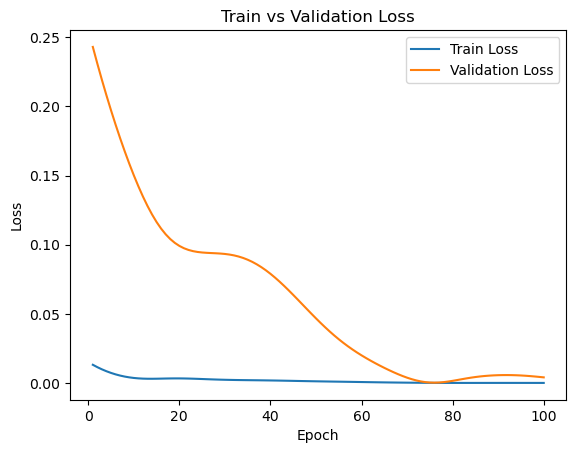

In [ ]:
# Here I am using the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model Training 
model_training(model, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

In [ ]:
# Evaluating on the test set
eval_loss, predictions, actual = test_step(model, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

# Experiments

## Hidden size

Epoch 10, Train Loss: 0.0037, Validation Loss: 0.1689
Epoch 20, Train Loss: 0.0035, Validation Loss: 0.1420
Epoch 30, Train Loss: 0.0023, Validation Loss: 0.0899
Epoch 40, Train Loss: 0.0015, Validation Loss: 0.0669
Epoch 50, Train Loss: 0.0008, Validation Loss: 0.0362
Epoch 60, Train Loss: 0.0002, Validation Loss: 0.0058
Epoch 70, Train Loss: 0.0001, Validation Loss: 0.0007
Epoch 80, Train Loss: 0.0001, Validation Loss: 0.0002
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0009
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0004


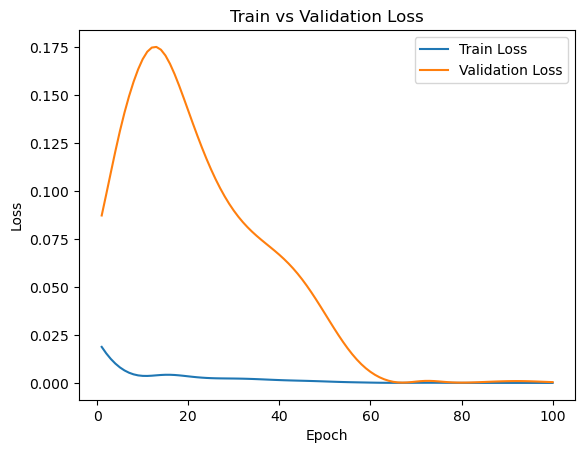

In [25]:
# Experiment with hidden size
hidden_size = 64
model_2 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_2.to(device)

optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
model_training(model_2, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.0042


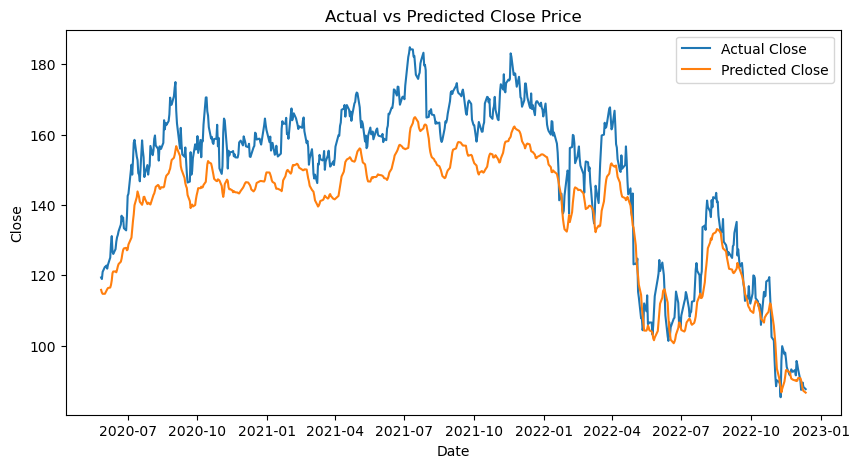

In [26]:
eval_loss, predictions, actual = test_step(model_2, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

Epoch 10, Train Loss: 0.0045, Validation Loss: 0.1128
Epoch 20, Train Loss: 0.0026, Validation Loss: 0.1102
Epoch 30, Train Loss: 0.0013, Validation Loss: 0.0381
Epoch 40, Train Loss: 0.0002, Validation Loss: 0.0011
Epoch 50, Train Loss: 0.0002, Validation Loss: 0.0198
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0010
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0010
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0049
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0031
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0020


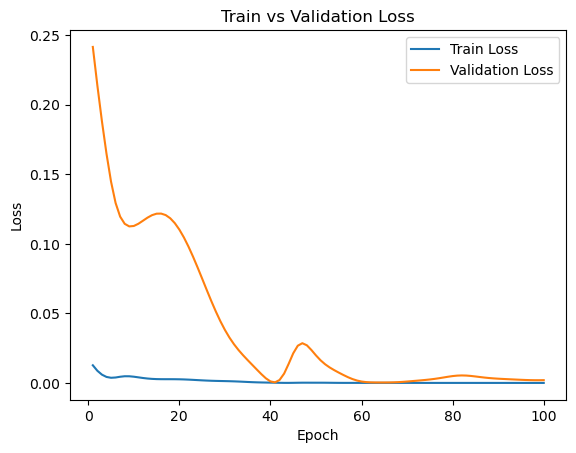

In [27]:
# Experiment with hidden size
hidden_size = 128
model_3 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_3.to(device)

optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)
model_training(model_3, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.0200


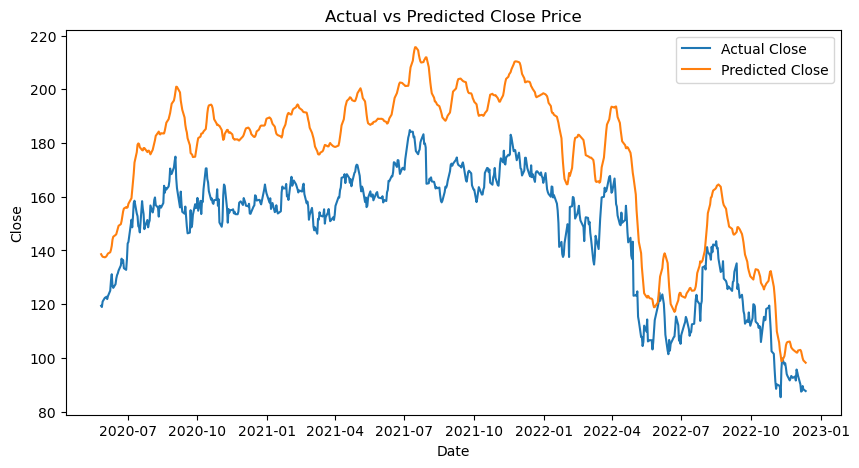

In [28]:
eval_loss, predictions, actual = test_step(model_3, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

## Learning Rate

Epoch 10, Train Loss: 0.0048, Validation Loss: 0.1869
Epoch 20, Train Loss: 0.0044, Validation Loss: 0.1913
Epoch 30, Train Loss: 0.0043, Validation Loss: 0.1900
Epoch 40, Train Loss: 0.0041, Validation Loss: 0.1837
Epoch 50, Train Loss: 0.0040, Validation Loss: 0.1756
Epoch 60, Train Loss: 0.0038, Validation Loss: 0.1685
Epoch 70, Train Loss: 0.0037, Validation Loss: 0.1625
Epoch 80, Train Loss: 0.0035, Validation Loss: 0.1570
Epoch 90, Train Loss: 0.0034, Validation Loss: 0.1510
Epoch 100, Train Loss: 0.0032, Validation Loss: 0.1445


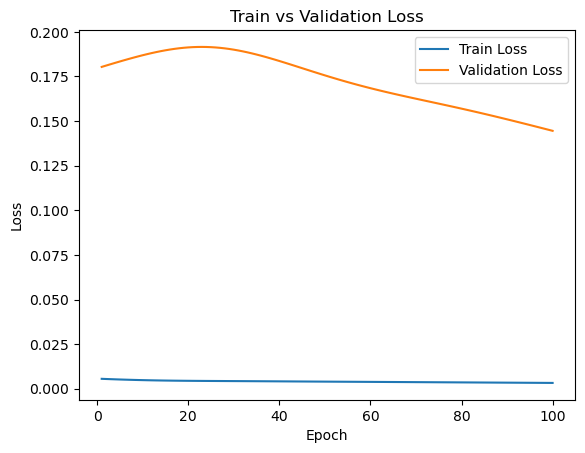

In [29]:
# Experiment with learning rate
# Here I am usng hidden_size = 64 as we had the lowest MSE score

learning_rate = 0.0001
hidden_size = 64
model_4 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_4.to(device)

optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)
model_training(model_4, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.4713


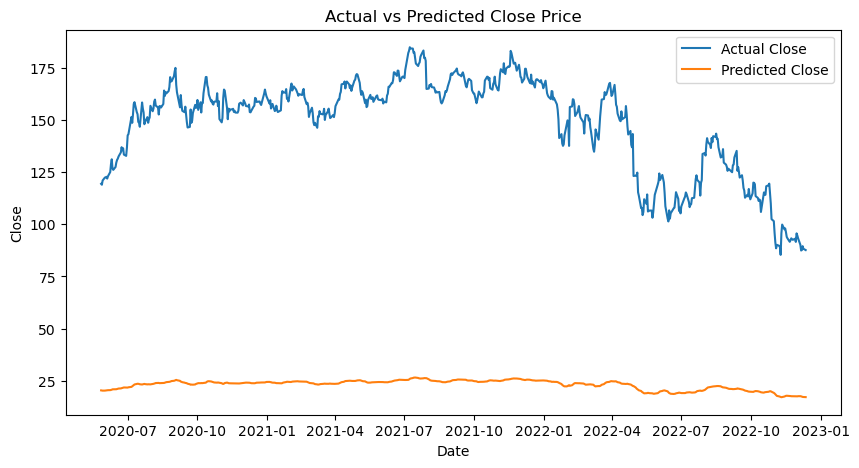

In [30]:
eval_loss, predictions, actual = test_step(model_4, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

Epoch 10, Train Loss: 0.0015, Validation Loss: 0.0420
Epoch 20, Train Loss: 0.0005, Validation Loss: 0.0254
Epoch 30, Train Loss: 0.0001, Validation Loss: 0.0045
Epoch 40, Train Loss: 0.0000, Validation Loss: 0.0018
Epoch 50, Train Loss: 0.0000, Validation Loss: 0.0003
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0003
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0001


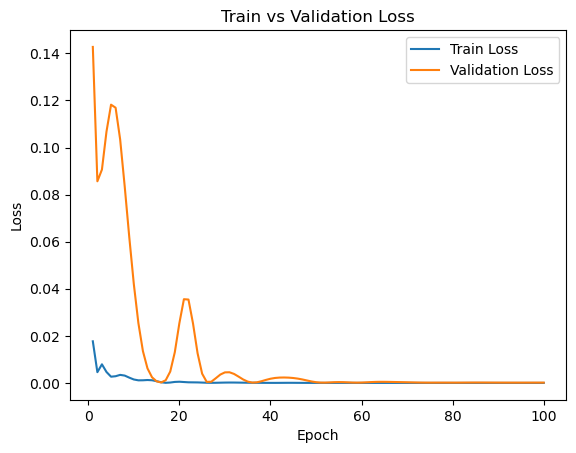

In [31]:
# Experiment with learning rate
# Here I am usng hidden_size = 64 as we had the lowest MSE score
learning_rate = 0.01
hidden_size = 64
model_5 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_5.to(device)

optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)
model_training(model_5, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.0026


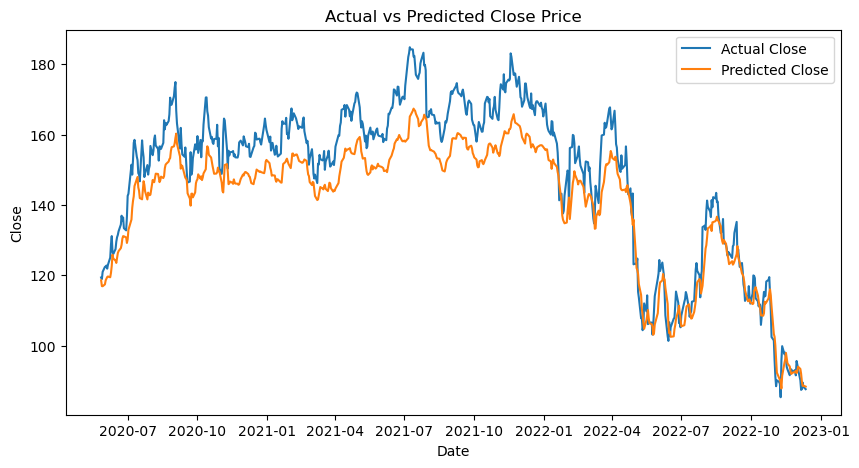

In [32]:
eval_loss, predictions, actual = test_step(model_5, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

## Timestamp

In [20]:
# Convering data to the sequence (required format) 
# past 15 days
X, y, date = convert_data_to_sequence(amazon_data_prep, 15)
print(X.shape, y.shape)


train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y, target_date = split_data(X, y)
# Shape of the data
print('Shape of the data: ')
print(train_data_X.shape, val_data_X.shape, test_data_X.shape)
print(train_data_y.shape, val_data_y.shape, test_data_y.shape)


train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y = conver_to_tensor(train_data_X, train_data_y, 
                                                                                                val_data_X, val_data_y, test_data_X, test_data_y)

(6423, 15, 5) (6423, 1)
Shape of the data: 
(5139, 15, 5) (642, 15, 5) (642, 15, 5)
(5139, 1) (642, 1) (642, 1)


In [21]:
#parameters
num_epoch = 100

# model parameters
input_size = 5
hidden_size = 64
num_layers = 1
learning_rate = 0.01

Epoch 10, Train Loss: 0.0015, Validation Loss: 0.0653
Epoch 20, Train Loss: 0.0002, Validation Loss: 0.0030
Epoch 30, Train Loss: 0.0001, Validation Loss: 0.0039
Epoch 40, Train Loss: 0.0001, Validation Loss: 0.0005
Epoch 50, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0002


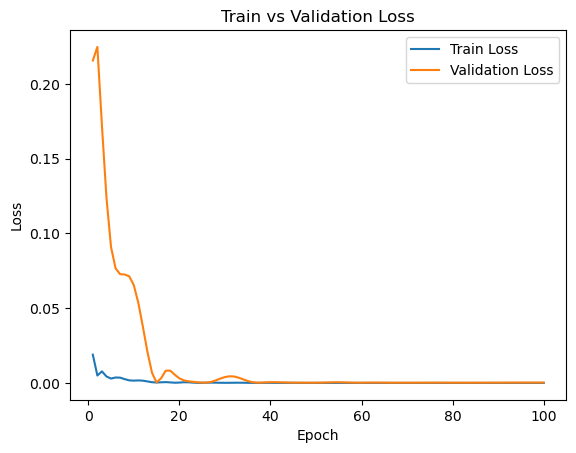

In [33]:
model_6 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_6.to(device)

optimizer = optim.Adam(model_6.parameters(), lr=learning_rate)
model_training(model_6, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.0109


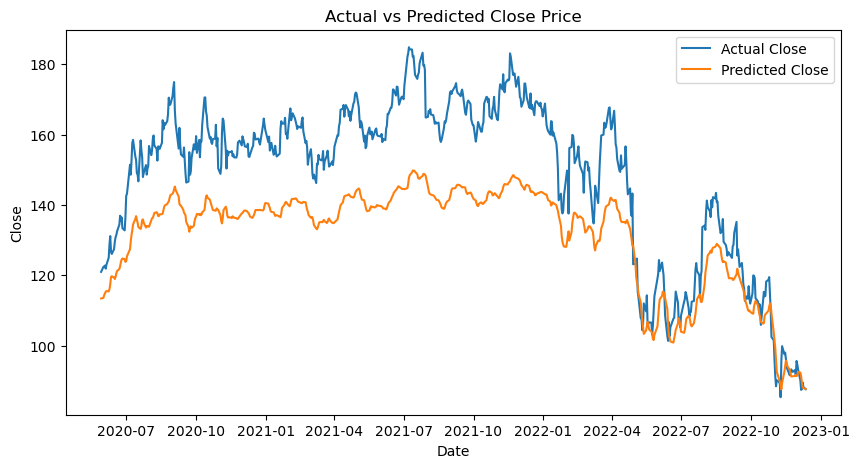

In [34]:
eval_loss, predictions, actual = test_step(model_6, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

Epoch 10, Train Loss: 0.0043, Validation Loss: 0.1304
Epoch 20, Train Loss: 0.0018, Validation Loss: 0.0254
Epoch 30, Train Loss: 0.0005, Validation Loss: 0.0031
Epoch 40, Train Loss: 0.0001, Validation Loss: 0.0155
Epoch 50, Train Loss: 0.0001, Validation Loss: 0.0172
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0124
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0139
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0124
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0132
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0130


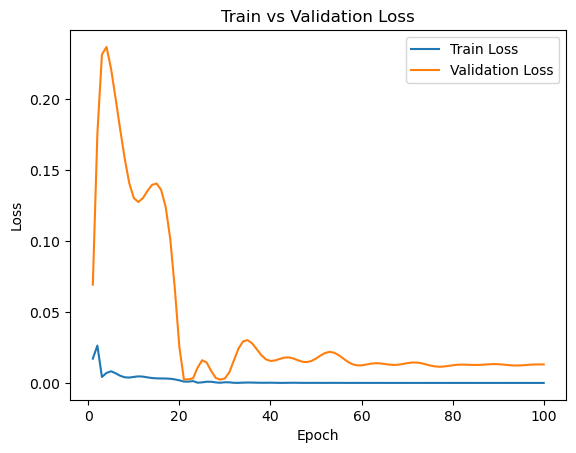

In [22]:
# Stacking LSTM
# Here the num_layers parameter represents the number of layers of LSTM
# I will stacking two layer of LSTM
num_layers = 2
hidden_size = 64
learning_rate = 0.01

model_8 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_8.to(device)

optimizer = optim.Adam(model_8.parameters(), lr=learning_rate)
model_training(model_8, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.1477


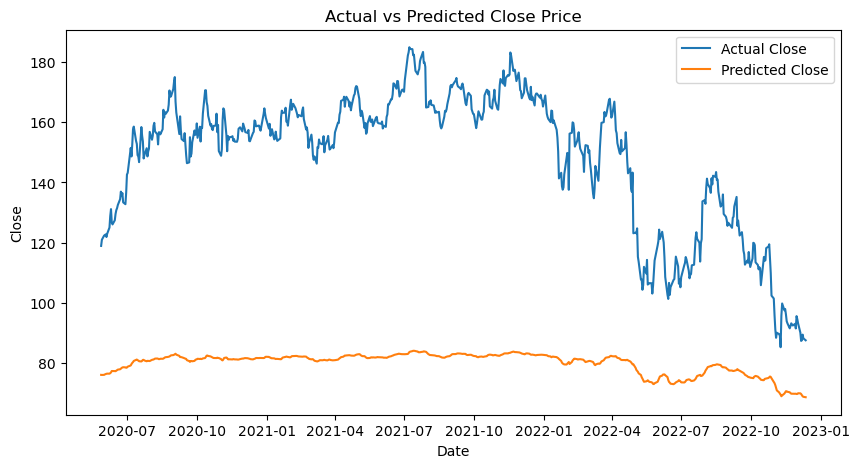

In [23]:
eval_loss, predictions, actual = test_step(model_8, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

In [24]:
# Past 30 Days

X, y, date = convert_data_to_sequence(amazon_data_prep, 30)
print(X.shape, y.shape)


train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y, target_date = split_data(X, y)
# Shape of the data
print('Shape of the data: ')
print(train_data_X.shape, val_data_X.shape, test_data_X.shape)
print(train_data_y.shape, val_data_y.shape, test_data_y.shape)


train_data_X, train_data_y, val_data_X, val_data_y, test_data_X, test_data_y = conver_to_tensor(train_data_X, train_data_y, 
                                                                                                val_data_X, val_data_y, test_data_X, test_data_y)

(6408, 30, 5) (6408, 1)
Shape of the data: 
(5127, 30, 5) (640, 30, 5) (641, 30, 5)
(5127, 1) (640, 1) (641, 1)


Epoch 10, Train Loss: 0.0090, Validation Loss: 0.1469
Epoch 20, Train Loss: 0.0041, Validation Loss: 0.1870
Epoch 30, Train Loss: 0.0038, Validation Loss: 0.1586
Epoch 40, Train Loss: 0.0026, Validation Loss: 0.1137
Epoch 50, Train Loss: 0.0020, Validation Loss: 0.0848
Epoch 60, Train Loss: 0.0013, Validation Loss: 0.0629
Epoch 70, Train Loss: 0.0007, Validation Loss: 0.0372
Epoch 80, Train Loss: 0.0002, Validation Loss: 0.0150
Epoch 90, Train Loss: 0.0001, Validation Loss: 0.0043
Epoch 100, Train Loss: 0.0001, Validation Loss: 0.0029


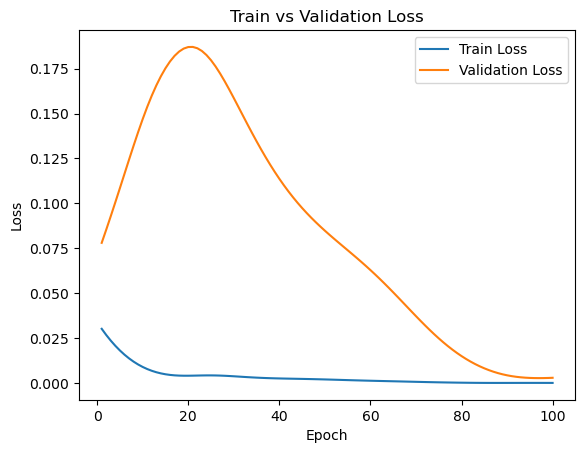

In [29]:
model_7 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_7.to(device)

optimizer = optim.Adam(model_7.parameters(), lr=learning_rate)
model_training(model_7, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.0464


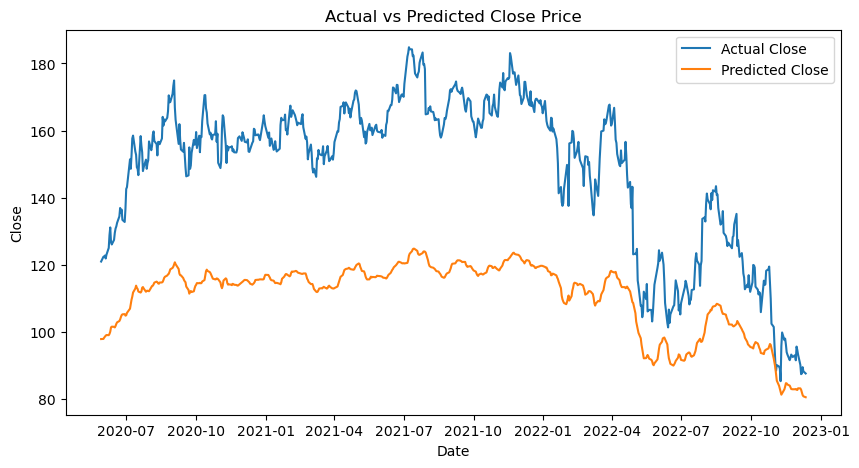

In [30]:
eval_loss, predictions, actual = test_step(model_7, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

Epoch 10, Train Loss: 0.0009, Validation Loss: 0.0305
Epoch 20, Train Loss: 0.0002, Validation Loss: 0.0093
Epoch 30, Train Loss: 0.0001, Validation Loss: 0.0206
Epoch 40, Train Loss: 0.0001, Validation Loss: 0.0192
Epoch 50, Train Loss: 0.0000, Validation Loss: 0.0195
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0189
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0163
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0156
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0144
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0135


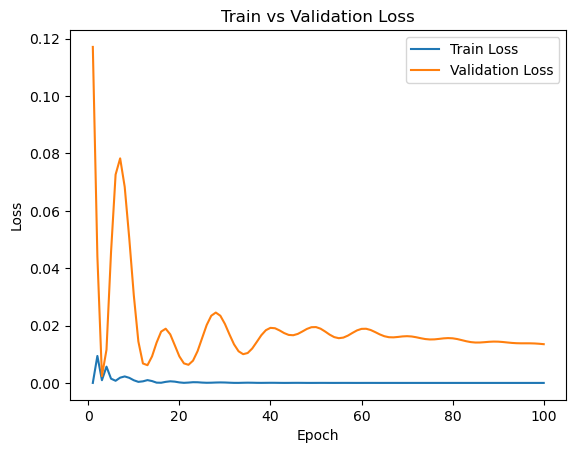

In [25]:
# Stacking LSTM
# Here the num_layers parameter represents the number of layers of LSTM
# I will stacking two layer of LSTM
num_layers = 2
hidden_size = 64
learning_rate = 0.01

model_9 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_9.to(device)

optimizer = optim.Adam(model_8.parameters(), lr=learning_rate)
model_training(model_8, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)

Testing Loss (Mean Squared Error): 0.5450


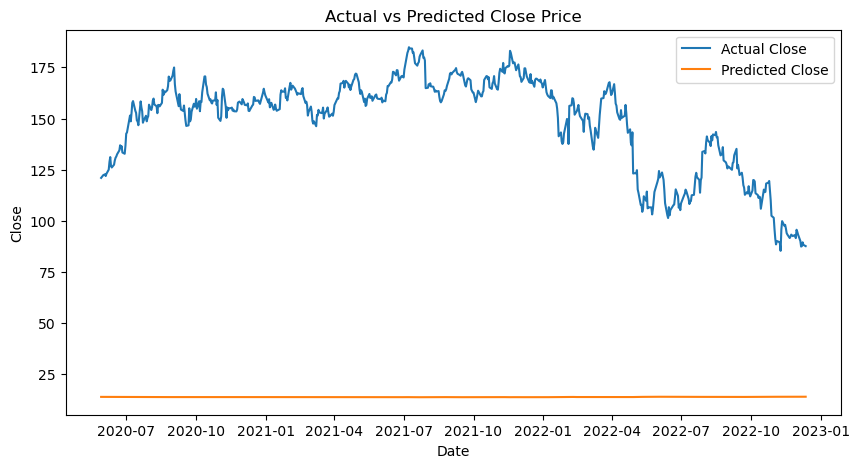

In [26]:
eval_loss, predictions, actual = test_step(model_9, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

## Comparison

In [42]:
# Vanila RNN
# Model -> (RNN)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # As train_data_X == (observation, seq, input_size) so batch_first=True
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :] # Taking only the last time step as here I am following many to one method
        out = self.fc(out)
        return out

In [43]:
#parameters
num_epoch = 100

# model parameters
input_size = 5
hidden_size = 64
num_layers = 1
learning_rate = 0.01

Epoch 10, Train Loss: 0.0042, Validation Loss: 0.0433
Epoch 20, Train Loss: 0.0005, Validation Loss: 0.0230
Epoch 30, Train Loss: 0.0002, Validation Loss: 0.0056
Epoch 40, Train Loss: 0.0001, Validation Loss: 0.0041
Epoch 50, Train Loss: 0.0000, Validation Loss: 0.0014
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0012
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0010
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0009
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0009
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0009


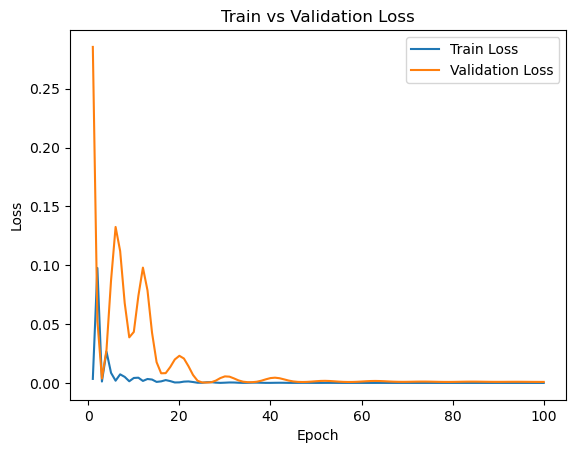

In [44]:
model_rnn = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_rnn.to(device)

optimizer = optim.Adam(model_rnn.parameters(), lr=learning_rate)
model_training(model_rnn, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)


Testing Loss (Mean Squared Error): 0.0150


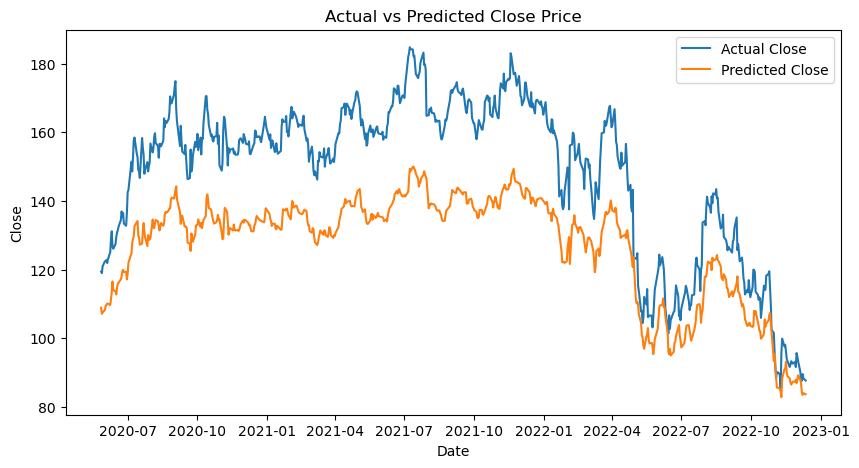

In [46]:
eval_loss, predictions, actual = test_step(model_rnn, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)

In [47]:
# Gated Recurrent Unit
# Model -> (GRU)
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # As train_data_X == (observation, seq, input_size) so batch_first=True
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :] # Taking only the last time step as here I am following many to one method
        out = self.fc(out)
        return out

Epoch 10, Train Loss: 0.0021, Validation Loss: 0.0309
Epoch 20, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 30, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 40, Train Loss: 0.0000, Validation Loss: 0.0003
Epoch 50, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 60, Train Loss: 0.0000, Validation Loss: 0.0002
Epoch 70, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 80, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 90, Train Loss: 0.0000, Validation Loss: 0.0001
Epoch 100, Train Loss: 0.0000, Validation Loss: 0.0001


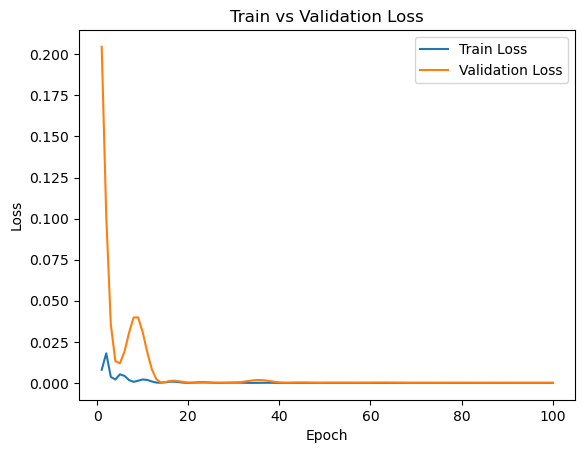

In [48]:
model_gru = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model_gru.to(device)

optimizer = optim.Adam(model_gru.parameters(), lr=learning_rate)
model_training(model_gru, train_data_X, train_data_y, val_data_X, val_data_y, num_epoch, optimizer)


Testing Loss (Mean Squared Error): 0.0010


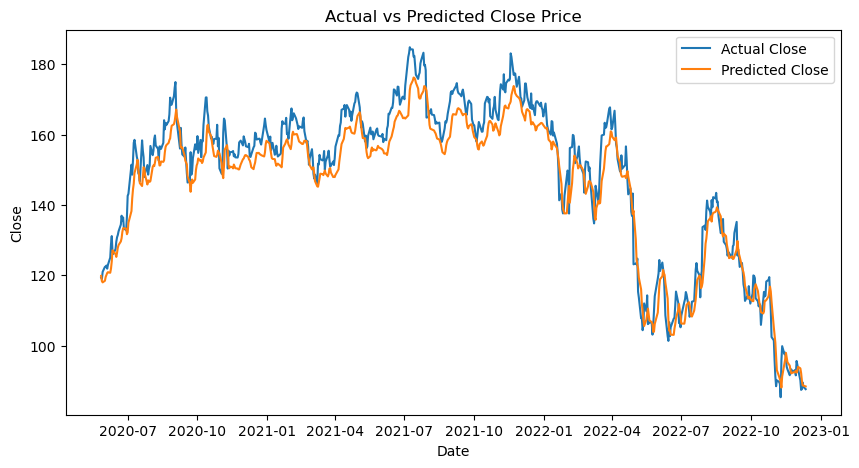

In [49]:
eval_loss, predictions, actual = test_step(model_gru, test_data_X, test_data_y, scaler)
actual_vs_pred(actual, predictions)